In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Dev sector

In [2]:
# Queue of Events
class EventsQueue:
    def __init__(self):
        self.globalTime = 0
        self.MEvents = []

    def QueueSize(self):
        return len(self.MEvents)

    def AddEvent(self, MEvent):
        count = len(self.MEvents)
        if count == 0:
            self.MEvents.append(MEvent)
            return 0

        if(MEvent.eTime >= self.MEvents[count - 1].eTime):
            self.MEvents.append(MEvent)
            return 0

        for i in range(0, count-1):
            if (MEvent.eTime >= self.MEvents[i].eTime):
                if (MEvent.eTime < self.MEvents[i + 1].eTime):
                    self.MEvents.insert(i + 1, MEvent)
                    return 0

    def ProcessNextEvent(self):
        if (len(self.MEvents) == 0):
            return 0
        self.MEvents[0].Execute()
        self.globalTime = self.MEvents[0].eTime
        del self.MEvents[0]


In [3]:
# Discrete Event System Specification
class DEVS:
    EQ = EventsQueue()
    GlobalTime = 0.0

    def __init__(self):
        pass

    @staticmethod
    def ProcessNextEvent():
        DEVS.EQ.ProcessNextEvent()
        DEVS.GlobalTime = DEVS.EQ.globalTime


In [4]:
# ---- Customer Statistics ----
class customerStat:
    def __init__(self):
        self.id = -1
        self.arrivalTime = -1
        self.serviceTime = -1
        self.interArrivalTime = 0
        self.serviceBegins = -1
        self.waitingTimeInQueue = 0
        self.serviceEnds = -1
        self.timeInSystem = -1
        self.idleTimeOfServer = 0


# General queue

In [5]:
# ---- Arrival Event ----
class ArrivalEvent_1gq:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats) > 0):
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
              
        if(DEVS.newId < maxAngents-1):
            NextArrival = ArrivalEvent_1gq()
            NextArrival.eTime = self.eTime + random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)

        # server is Free
        if (DEVS.serverIdle == True):
            DEVS.serverIdle = False
            print("server is Busy")
            Service = ServiceEvent_1gq()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime+serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


In [6]:
# ---- Service (END) Event ----
class ServiceEvent_1gq:
    def __init__(self):
         self.eTime = 0.0
         self.id = 0
        
    def Execute(self):        
        ind = [i for i,val in enumerate(DEVS.stats) if val.id == self.id][0]

        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        
        print("Time %d"%self.eTime,"Service finished")
        if(len(DEVS.customerQueue) > 0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i,val in enumerate(DEVS.stats) if val.id == qid][0]

            Service = ServiceEvent_1gq()
            serviceTime = custm.rvs()  
            Service.eTime = self.eTime+serviceTime
            Service.id = qid

            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime            
            DEVS.EQ.AddEvent(Service)
            
            print("take new customer from the queue")            
        else:
            DEVS.serverIdle = True
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# Shortest Queue

In [7]:
# ---- Arrival Event ----
class ArrivalEvent_2sq:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats) > 0):
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
        
        if(DEVS.newId < maxAngents-1):
            NextArrival = ArrivalEvent_2sq()
            NextArrival.eTime = self.eTime + random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)

        # server is Free
        if (DEVS.serverIdle == True):
            DEVS.serverIdle = False
            print("server is Busy")
            Service = ServiceEvent_2sq()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime+serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
            DEVS.queueLen.append([customer.id])
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            DEVS.queueLen[-1].append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


In [8]:
# ---- Service (END) Event ----
class ServiceEvent_2sq:
    def __init__(self):
         self.eTime = 0.0
         self.id = 0
        
    def Execute(self):        
        ind = [i for i,val in enumerate(DEVS.stats) if val.id == self.id][0]

        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        
        print("Time %d"%self.eTime,"Service finished")
        if(len(DEVS.customerQueue) > 0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i,val in enumerate(DEVS.stats) if val.id == qid][0]

            Service = ServiceEvent_2sq()
            serviceTime = custm.rvs()  
            Service.eTime = self.eTime+serviceTime
            Service.id = qid

            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime            
            DEVS.EQ.AddEvent(Service)
            
            print("take new customer from the queue")            
        else:
            DEVS.serverIdle = True
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# Dynamic General Queue

In [9]:
# ---- Arrival Event ----
class ArrivalEvent_3dgq:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats) > 0):
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
        if(DEVS.newId < maxAngents-1):
            NextArrival = ArrivalEvent_3dgq()
            NextArrival.eTime = self.eTime + random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)

        # server is Free
        if (DEVS.serverIdle == True):
            DEVS.serverIdle = False
            print("server is Busy")
            Service = ServiceEvent_3dgq()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime+serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


In [10]:
# ---- Service (END) Event ----
class ServiceEvent_3dgq:
    def __init__(self):
         self.eTime = 0.0
         self.id = 0
        
    def Execute(self):        
        ind = [i for i,val in enumerate(DEVS.stats) if val.id == self.id][0]

        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        
        print("Time %d"%self.eTime,"Service finished")
        if(len(DEVS.customerQueue) > 0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i,val in enumerate(DEVS.stats) if val.id == qid][0]

            Service = ServiceEvent_3dgq()
            serviceTime = custm.rvs()  
            Service.eTime = self.eTime+serviceTime
            Service.id = qid

            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime            
            DEVS.EQ.AddEvent(Service)
            
            print("take new customer from the queue")            
        else:
            DEVS.serverIdle = True
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# Dynamic Shortest Queue

In [11]:
# ---- Arrival Event ----
class ArrivalEvent_4dsq:
    def __init__(self):
        self.eTime = 0.0

    def Execute(self):
        customer = customerStat()
        customer.id = DEVS.newId
        customer.arrivalTime = self.eTime
        if(len(DEVS.stats) > 0):
            customer.interArrivalTime = customer.arrivalTime - DEVS.stats[-1].arrivalTime

        print("Time %d" % self.eTime,
              " Arrival Event of agent {0}".format(customer.id))
        if(DEVS.newId < maxAngents-1):
            NextArrival = ArrivalEvent_4dsq()
            NextArrival.eTime = self.eTime + random.randint(arrivalRateMin, arrivalRateMax)
            DEVS.EQ.AddEvent(NextArrival)

        # server is Free
        if (DEVS.serverIdle == True):
            DEVS.serverIdle = False
            print("server is Busy")
            Service = ServiceEvent_2sq()
            serviceTime = custm.rvs()
            customer.serviceTime = serviceTime
            customer.serviceBegins = self.eTime  # current time
            Service.eTime = self.eTime+serviceTime
            Service.id = customer.id
            DEVS.EQ.AddEvent(Service)
        # server is Busy
        else:
            # increase waiting line
            DEVS.customerQueue.append(customer.id)
            print("customerQueue = %d" % len(DEVS.customerQueue))

        DEVS.newId = DEVS.newId + 1
        DEVS.stats.append(customer)


In [12]:
# ---- Service (END) Event ----
class ServiceEvent_4dsq:
    def __init__(self):
         self.eTime = 0.0
         self.id = 0
        
    def Execute(self):        
        ind = [i for i,val in enumerate(DEVS.stats) if val.id == self.id][0]

        DEVS.stats[ind].serviceEnds = self.eTime
        DEVS.stats[ind].timeInSystem = DEVS.stats[ind].serviceEnds - DEVS.stats[ind].arrivalTime 
        DEVS.stats[ind].waitingTimeInQueue = DEVS.stats[ind].serviceBegins - DEVS.stats[ind].arrivalTime # 0 without queue
        DEVS.stats[ind].idleTimeOfServer = DEVS.stats[ind].serviceBegins - DEVS.lastServedTime
        
        print("Time %d"%self.eTime,"Service finished")
        if(len(DEVS.customerQueue) > 0):
            qid = DEVS.customerQueue.pop(0)
            qind = [i for i,val in enumerate(DEVS.stats) if val.id == qid][0]

            Service = ServiceEvent_4dsq()
            serviceTime = custm.rvs()  
            Service.eTime = self.eTime+serviceTime
            Service.id = qid

            DEVS.stats[qind].serviceBegins = self.eTime
            DEVS.stats[qind].serviceTime = serviceTime            
            DEVS.EQ.AddEvent(Service)
            
            print("take new customer from the queue")            
        else:
            DEVS.serverIdle = True
            print("server is Idle (do nothing)")

        DEVS.lastServedTime = self.eTime


# Settings sector

In [13]:
maxAngents = 100

arrivalRateMin = 1
arrivalRateMax = 8

service_xk = np.arange(6)+1
service_pk = (0.1, 0.2, 0.3, 0.25, 0.1, 0.05)

custm = stats.rv_discrete(name='custm', values=(service_xk, service_pk))


# Running sector

In [17]:
# run simulation
AE = ArrivalEvent_1gq()
DEVS.EQ.AddEvent(AE)

# simulation attributes
DEVS.customerQueue = []
DEVS.stats = []
DEVS.newId = 0
DEVS.serverIdle = True
DEVS.lastServedTime = 0  # for Idle time

DEVS.queueLen = []


In [18]:
# --- SIMULATION ---
while DEVS.EQ.QueueSize() > 0:
    DEVS.ProcessNextEvent()

Time 0  Arrival Event of agent 0
server is Busy
Time 2 Service finished
server is Idle (do nothing)
Time 5  Arrival Event of agent 1
server is Busy
Time 9 Service finished
server is Idle (do nothing)
Time 11  Arrival Event of agent 2
server is Busy
Time 14 Service finished
server is Idle (do nothing)
Time 15  Arrival Event of agent 3
server is Busy
Time 17 Service finished
server is Idle (do nothing)
Time 23  Arrival Event of agent 4
server is Busy
Time 29  Arrival Event of agent 5
customerQueue = 1
Time 29 Service finished
take new customer from the queue
Time 31  Arrival Event of agent 6
customerQueue = 1
Time 32 Service finished
take new customer from the queue
Time 33  Arrival Event of agent 7
customerQueue = 1
Time 35 Service finished
take new customer from the queue
Time 37  Arrival Event of agent 8
customerQueue = 1
Time 38  Arrival Event of agent 9
customerQueue = 2
Time 40 Service finished
take new customer from the queue
Time 41  Arrival Event of agent 10
customerQueue = 2
Ti


Average waiting time: 1.06

Probability that a customer has to wait: 0.42

Probability of an Idle server: 0.30

Average service time: 3.26

Average time between arrivals: 4.66

Average waiting time for those who wait: 2.52

Average time a customer spends in the system: 4.32

Average time a customer spends in the system (alternative): 4.32


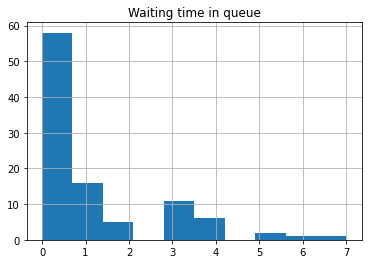

In [16]:
# --- STATISTICS ---

#  --- store all in file  ---
f = open('output.csv', 'w')
f.write("Id;Interarrival Time;Arrival Time;Service Time;Time Service Begins;Waiting time in Queue;Time Service Ends;Time Customer Spends in System;Idle time of Server\n")
for s in DEVS.stats:
    f.write("{0};{1};{2};{3};{4};{5};{6};{7};{8}\n".format(s.id, s.interArrivalTime, s.arrivalTime,
            s.serviceTime, s.serviceBegins, s.waitingTimeInQueue, s.serviceEnds, s.timeInSystem, s.idleTimeOfServer))
f.close()

# 1) Average waiting time in queue
avTimeInQueue = sum([x.waitingTimeInQueue for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage waiting time: {0:.2f}".format(avTimeInQueue))

# 2) Probability that a customer has to wait
probToWait = len(
    [x for x in DEVS.stats if x.waitingTimeInQueue > 0])/len(DEVS.stats)
print("\nProbability that a customer has to wait: {0:.2f}".format(probToWait))

# 3) Probability of an Idle server
probIdle = sum([x.idleTimeOfServer for x in DEVS.stats])/DEVS.GlobalTime
print("\nProbability of an Idle server: {0:.2f}".format(probIdle))

# 4) Average service time (theoretical 3.2)
avServiceTime = sum([x.serviceTime for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage service time: {0:.2f}".format(avServiceTime))

# 5) Average time between arrivals (theoretical 4.5)
avTimeBetwArr = sum(
    [x.interArrivalTime for x in DEVS.stats])/(len(DEVS.stats)-1)
print("\nAverage time between arrivals: {0:.2f}".format(avTimeBetwArr))

# 6) Average waiting time for those who wait
numOfCustWhoWait = len([x for x in DEVS.stats if x.waitingTimeInQueue > 0])
avTimeWhoWait = sum(
    [x.waitingTimeInQueue for x in DEVS.stats])/numOfCustWhoWait
print("\nAverage waiting time for those who wait: {0:.2f}".format(
    avTimeWhoWait))

# 7) Average time a customer spends in the system
avTimeInTheSystem1 = sum([x.timeInSystem for x in DEVS.stats])/len(DEVS.stats)
print("\nAverage time a customer spends in the system: {0:.2f}".format(
    avTimeInTheSystem1))

avTimeInTheSystem2 = avTimeInQueue + avServiceTime
print("\nAverage time a customer spends in the system (alternative): {0:.2f}".format(
    avTimeInTheSystem2))


def DrawSampleHistogram(R, title, bins=None):
    fig = plt.figure()
    x = np.arange(len(R))
    plt.grid()
    if(bins is None):
        plt.hist(R, range=None)
    else:
        plt.hist(R, bins=bins, range=None)
    plt.title(title)
    plt.show()


DrawSampleHistogram(
    [x.waitingTimeInQueue for x in DEVS.stats], "Waiting time in queue")


# Implement and compare all (four) models (by average queue size, total working etc.)

# Draw server's dynamic through the time (for dynamic queues)